Sequences saved to hmpox_sequences.fasta
Sequences saved to other_virus_sequences.fasta


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

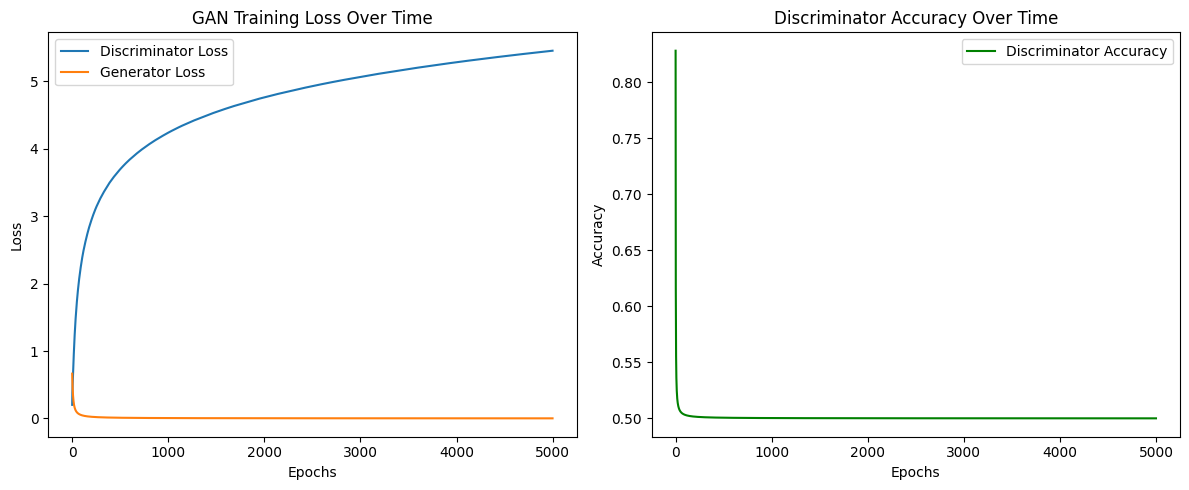

In [ ]:
!pip install numpy pandas tensorflow matplotlib seaborn biopython scikit-learn fastapi uvicorn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from Bio import SeqIO, Entrez

# Set Entrez email (Required by NCBI API)
Entrez.email = "shamuraanim7@gmail.com"

# Function to fetch FASTA files from NCBI
def fetch_fasta_from_ncbi(accessions, output_fasta):
    with open(output_fasta, "w") as fasta_out:
        for acc in accessions:
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="fasta", retmode="text")
            fasta_out.write(handle.read())
    print(f"Sequences saved to {output_fasta}")

# Function to generate k-mer features
def extract_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Load and preprocess genomic sequences
def load_genomic_data(fasta_files, labels):
    sequences = []
    sequence_labels = []
    for file, label in zip(fasta_files, labels):
        for record in SeqIO.parse(file, "fasta"):
            kmer_seq = extract_kmers(str(record.seq))
            sequences.append(" ".join(kmer_seq))
            sequence_labels.append(label)
    return sequences, sequence_labels

# Fetch NCBI sequences
hmpox_accessions = ["2912461487"]
other_virus_accessions = ["2892913101"]
fetch_fasta_from_ncbi(hmpox_accessions, "hmpox_sequences.fasta")
fetch_fasta_from_ncbi(other_virus_accessions, "other_virus_sequences.fasta")

# Load data
fasta_files = ["hmpox_sequences.fasta", "other_virus_sequences.fasta"]
labels = ["HMPox", "Other_Virus"]
sequences, sequence_labels = load_genomic_data(fasta_files, labels)

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sequences)
X = tokenizer.texts_to_sequences(sequences)
X = pad_sequences(X, maxlen=500)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(sequence_labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GAN Parameters
latent_dim = 100
sequence_length = 500
gen_output_dim = sequence_length

# Generator Model
def build_generator():
    model = Sequential([
        Dense(256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dense(gen_output_dim, activation='tanh')
    ])
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential([
        Dense(512, input_dim=sequence_length),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

# Build and Compile GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.trainable = False

z = Input(shape=(latent_dim,))
fake_seq = generator(z)
validity = discriminator(fake_seq)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Store training history
d_losses = []
g_losses = []
d_accuracies = []

# Train GAN
def train_gan_with_metrics(epochs=5000, batch_size=32):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_sequences = generator.predict(noise)
        real_sequences = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))

        # Train Discriminator
        d_loss_real, d_acc_real = discriminator.train_on_batch(real_sequences, labels_real)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(gen_sequences, labels_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, labels_real)

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        d_accuracies.append(d_acc)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss}, G Loss: {g_loss}, D Accuracy: {d_acc}")

# Train the GAN
train_gan_with_metrics(epochs=5000)

# Generate synthetic sequences
def generate_synthetic_data(n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    synthetic_sequences = generator.predict(noise)
    return synthetic_sequences

# Generate synthetic data and add to training set
synthetic_data = generate_synthetic_data()
X_train = np.vstack((X_train, synthetic_data))
y_train = np.hstack((y_train, np.random.randint(0, 2, synthetic_data.shape[0])))

# Train a classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)

# Predict on test data
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classifier Accuracy on Test Set: {accuracy * 100:.2f}%")

# Plot results
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Loss Over Time")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Time")
plt.legend()

plt.tight_layout()
plt.show()
